# Compare lidar

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd 
import numpy as np

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
tstart  = np.datetime64('2023-08-24T03:00')
t_5AM  = np.datetime64('2023-08-24T05:00')
t_7AM  = np.datetime64('2023-08-24T07:00')
#tdeltas = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
tdeltas = [2.5,  3, 3.5, 4.0] 

In [3]:
datadir = '../../../'
# Open NetCDF files
ds_Hprof = xr.open_dataset(datadir+'/Data/Lidars/H_profiling_lidar_10min.nc')
ds_Hscan = xr.open_dataset(datadir+'/Data/Lidars/H_scanning_lidar_10min.nc')

ds_A1prof = xr.open_dataset(datadir+'/Phase2_Data/A1_profiling_lidar_10min.nc')
ds_A1scan = xr.open_dataset(datadir+'/Phase2_Data/A1_scanning_lidar_10min.nc')

ds_C1aprof = xr.open_dataset(datadir+'/Data/Lidars/C1a_profiling_lidar_2min.nc')

## Site A1 lidar

In [4]:
# For scanner
A1scan_z     = ds_A1scan['height']
tvec         = ds_A1scan['time'].data

A1scan_MMCdates     = []
A1scan_WS    = []
A1scan_WD    = []
A1scan_TKE   = []

for t in tdeltas:
    ttarget    = tstart + np.timedelta64(int(t*3600), 's')
    ttarget_m25 = ttarget - np.timedelta64(25, 'm')
    ttarget_p05 = ttarget + np.timedelta64(5, 'm')

    im25 = (np.where(tvec == ttarget_m25))[0][0]
    ip05 = (np.where(tvec == ttarget_p05))[0][0]

    WSm25 = ds_A1scan['WS'][im25, :]
    WSp05 = ds_A1scan['WS'][ip05, :]
    
    WDm25 = ds_A1scan['WD'][im25, :]
    WDp05 = ds_A1scan['WD'][ip05, :]

    TKEm25 = ds_A1scan['TKE'][im25, :]
    TKEp05 = ds_A1scan['TKE'][ip05, :]

    WStarget = (WSp05 - WSm25)/(30.0)*(25.0) + WSm25
    WDtarget = (WDp05 - WDm25)/(30.0)*(25.0) + WDm25
    TKEtarget = (TKEp05 - TKEm25)/(30.0)*(25.0) + TKEm25
    
    A1scan_MMCdates.append(ttarget)
    A1scan_WS.append(WStarget)
    A1scan_WD.append(WDtarget)
    A1scan_TKE.append(TKEtarget)
    #print(ttarget_m25, ttarget, ttarget_p5)

In [5]:
# For scanner
A1prof_z     = ds_A1prof['height']
tvec         = ds_A1prof['time'].data

#MMCdates     = []
A1prof_WS    = []
A1prof_WD    = []

for t in tdeltas:
    ttarget    = tstart + np.timedelta64(int(t*3600), 's')
    ttarget_m05 = ttarget - np.timedelta64(5, 'm')
    ttarget_p05 = ttarget + np.timedelta64(5, 'm')

    im05 = (np.where(tvec == ttarget_m05))[0][0]
    ip05 = (np.where(tvec == ttarget_p05))[0][0]

    WSm05 = ds_A1prof['U'][im05, :]
    WSp05 = ds_A1prof['U'][ip05, :]
    
    WDm05 = ds_A1prof['WD'][im05, :]
    WDp05 = ds_A1prof['WD'][ip05, :]

    WStarget = (WSp05 - WSm05)/(10.0)*(5.0) + WSm05
    WDtarget = (WDp05 - WDm05)/(10.0)*(5.0) + WDm05

    A1prof_WS.append(WStarget)
    A1prof_WD.append(WDtarget)

In [6]:
# Load AMR-Wind data
AMR_datA1 = []
AMR_dir  = 'AVG_lidar'
for t in tdeltas:
    tsec = t*3600.0
    AMR_datA1.append(pd.read_csv(AMR_dir+'/siteA1_AVG_%i.csv'%tsec))

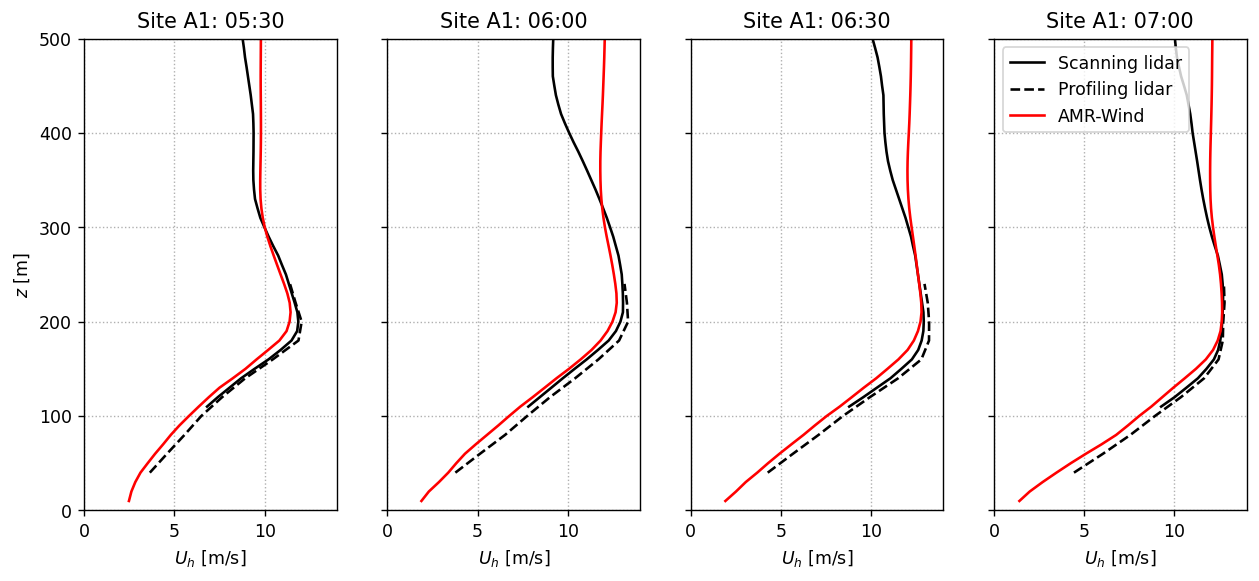

In [7]:
fig, axs = plt.subplots(1, len(tdeltas), figsize=(3*len(tdeltas),5), dpi=125, sharey=True)
for iWS, WS in enumerate(A1scan_WS):
    #plt.figure(figsize=(5,5), dpi=125)
    ax = axs[iWS]
    ax.plot(WS, A1scan_z, color='k', label='Scanning lidar')
    ax.plot(A1prof_WS[iWS], A1prof_z, color='k', ls='--', label='Profiling lidar')
    
    # process AMR-Wind data
    A1amr = AMR_datA1[iWS]
    zamr  = np.array(A1amr['z'])
    WSamr = np.array(np.sqrt(A1amr['velocityx_avg']**2 + A1amr['velocityy_avg']**2))
    ax.plot(WSamr, zamr, color='r', ls='-', label='AMR-Wind')
    ax.set_title('Site A1: '+str(A1scan_MMCdates[iWS])[11:16])#[:16])
    ax.set_ylim([0, 500])
    ax.set_xlim([0, 14])
    ax.grid(ls=':')
    ax.set_xlabel('$U_h$ [m/s]')
    
axs[0].set_ylabel('$z$ [m]')
axs[-1].legend(loc='upper left')

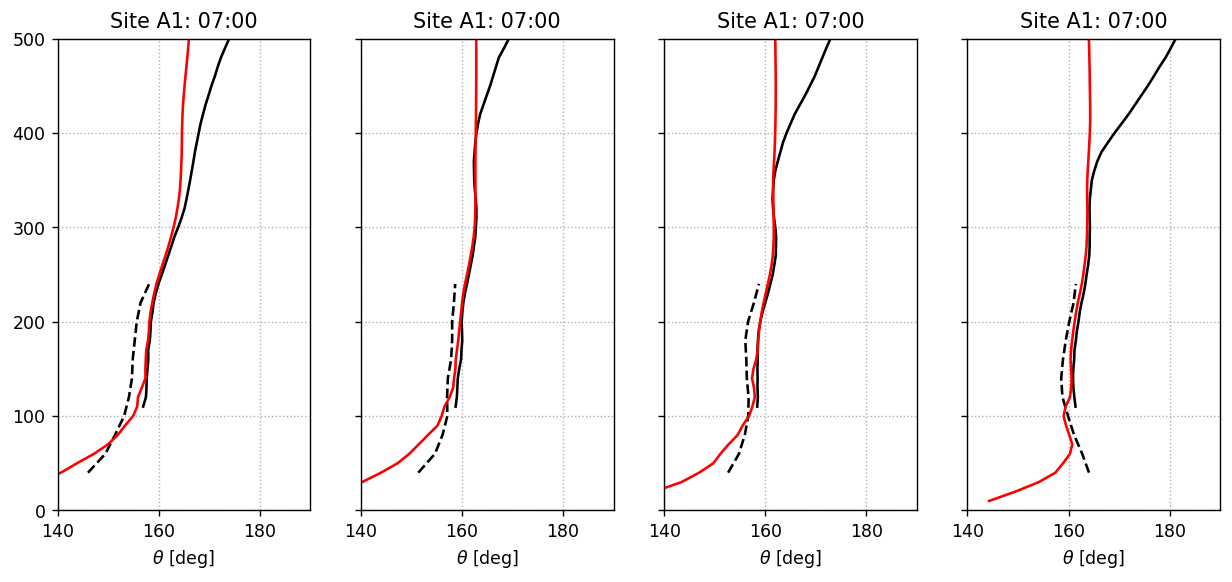

In [8]:
# Plot the wind direction
fig, axs = plt.subplots(1, len(tdeltas), figsize=(3*len(tdeltas),5), dpi=125, sharey=True)
for iWD, WD in enumerate(A1scan_WD):
    #plt.figure(figsize=(5,5), dpi=125)
    ax = axs[iWD]
    ax.plot(WD, A1scan_z, color='k', label='Scanning lidar')
    ax.plot(A1prof_WD[iWD], A1prof_z, color='k', ls='--', label='Profiling lidar')

    # process AMR-Wind data
    A1amr = AMR_datA1[iWD]
    zamr  = np.array(A1amr['z'])
    WDamr = 270.0 - np.arctan2( A1amr['velocityy_avg'],  A1amr['velocityx_avg'])*180.0/np.pi #np.array(np.sqrt(A1amr['velocityx_avg']**2 + A1amr['velocityy_avg']**2))
    ax.plot(np.array(WDamr), zamr, color='r', ls='-', label='AMR-Wind')
    
    ax.set_title('Site A1: '+str(A1scan_MMCdates[iWS])[11:16])#[:16])
    ax.set_ylim([0, 500])
    ax.set_xlim([140, 190])
    ax.grid(ls=':')
    ax.set_xlabel('$\\theta$ [deg]')

In [9]:
# Load AMR-Wind data
AMR_TKEA1 = []
AMR_dir  = 'AVG_lidar'
for t in tdeltas[:]:
    tsec = t*3600.0
    AMR_TKEA1.append(pd.read_csv(AMR_dir+'/siteA1_RESTRESS_%i.csv'%tsec))

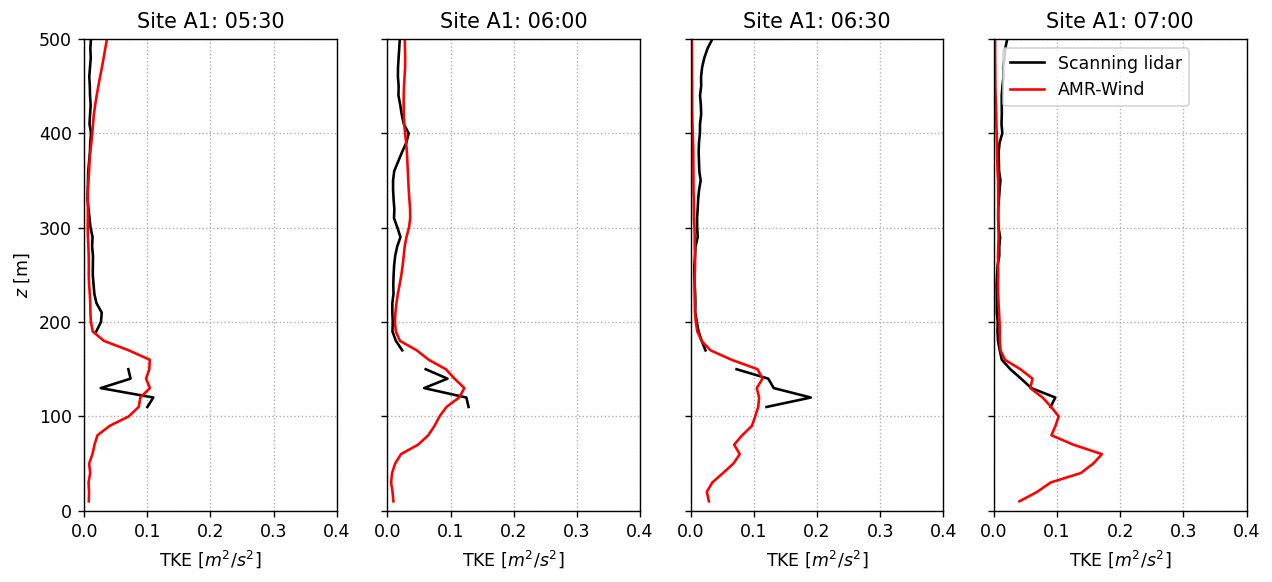

In [10]:
fig, axs = plt.subplots(1, len(tdeltas), figsize=(3*len(tdeltas),5), dpi=125, sharey=True)
for iWS, TKE in enumerate(A1scan_TKE[:]):
    #plt.figure(figsize=(5,5), dpi=125)
    ax = axs[iWS]
    ax.plot(TKE, A1scan_z, color='k', label='Scanning lidar')
    #ax.plot(Hprof_WS[iWS], Hprof_z, color='k', ls='--', label='Profiling lidar')
    
    # process AMR-Wind data
    Hamr = AMR_TKEA1[iWS]
    zamr  = np.array(Hamr['z'])
    TKEamr = np.array(0.5*(Hamr['uu_avg'] + Hamr['vv_avg'] + Hamr['ww_avg']))
    ax.plot(TKEamr, zamr, color='r', ls='-', label='AMR-Wind')
    ax.set_title('Site A1: '+str(A1scan_MMCdates[iWS])[11:16])#[:16])
    ax.set_ylim([0, 500])
    ax.set_xlim([0, 0.4])
    ax.grid(ls=':')
    ax.set_xlabel('TKE [$m^2/s^2$]')
    
axs[0].set_ylabel('$z$ [m]')
axs[-1].legend(loc='upper left')

## Site H lidar

In [11]:
# For scanner
Hscan_z      = ds_Hscan['height']
tvec         = ds_Hscan['time'].data

Hscan_MMCdates     = []
Hscan_WS    = []
Hscan_WD    = []
Hscan_TKE   = []

for t in tdeltas:
    ttarget    = tstart + np.timedelta64(int(t*3600), 's')
    ttarget_m25 = ttarget - np.timedelta64(25, 'm')
    ttarget_p05 = ttarget + np.timedelta64(5, 'm')

    im25 = (np.where(tvec == ttarget_m25))[0][0]
    ip05 = (np.where(tvec == ttarget_p05))[0][0]

    WSm25 = ds_Hscan['WS'][im25, :]
    WSp05 = ds_Hscan['WS'][ip05, :]
    
    WDm25 = ds_Hscan['WD'][im25, :]
    WDp05 = ds_Hscan['WD'][ip05, :]

    TKEm25 = ds_Hscan['TKE'][im25, :]
    TKEp05 = ds_Hscan['TKE'][ip05, :]

    WStarget = (WSp05 - WSm25)/(30.0)*(25.0) + WSm25
    WDtarget = (WDp05 - WDm25)/(30.0)*(25.0) + WDm25
    TKEtarget = (TKEp05 - TKEm25)/(30.0)*(25.0) + TKEm25
    
    Hscan_MMCdates.append(ttarget)
    Hscan_WS.append(WStarget)
    Hscan_WD.append(WDtarget)
    Hscan_TKE.append(TKEtarget)
    #print(ttarget_m25, ttarget, ttarget_p5)    

In [12]:
# For profiling
Hprof_z      = ds_Hprof['height']
tvec         = ds_Hprof['time'].data

#MMCdates     = []
Hprof_WS    = []
Hprof_WD    = []

for t in tdeltas:
    ttarget    = tstart + np.timedelta64(int(t*3600), 's')
    ttarget_m05 = ttarget - np.timedelta64(5, 'm')
    ttarget_p05 = ttarget + np.timedelta64(5, 'm')

    im05 = (np.where(tvec == ttarget_m05))[0][0]
    ip05 = (np.where(tvec == ttarget_p05))[0][0]

    WSm05 = ds_Hprof['U'][im05, :]
    WSp05 = ds_Hprof['U'][ip05, :]
    
    WDm05 = ds_Hprof['WD'][im05, :]
    WDp05 = ds_Hprof['WD'][ip05, :]

    WStarget = (WSp05 - WSm05)/(10.0)*(5.0) + WSm05
    WDtarget = (WDp05 - WDm05)/(10.0)*(5.0) + WDm05

    Hprof_WS.append(WStarget)
    Hprof_WD.append(WDtarget)

In [13]:
# Load AMR-Wind data
AMR_datH = []
AMR_dir  = 'AVG_lidar'
for t in tdeltas:
    tsec = t*3600.0
    AMR_datH.append(pd.read_csv(AMR_dir+'/siteH_AVG_%i.csv'%tsec))

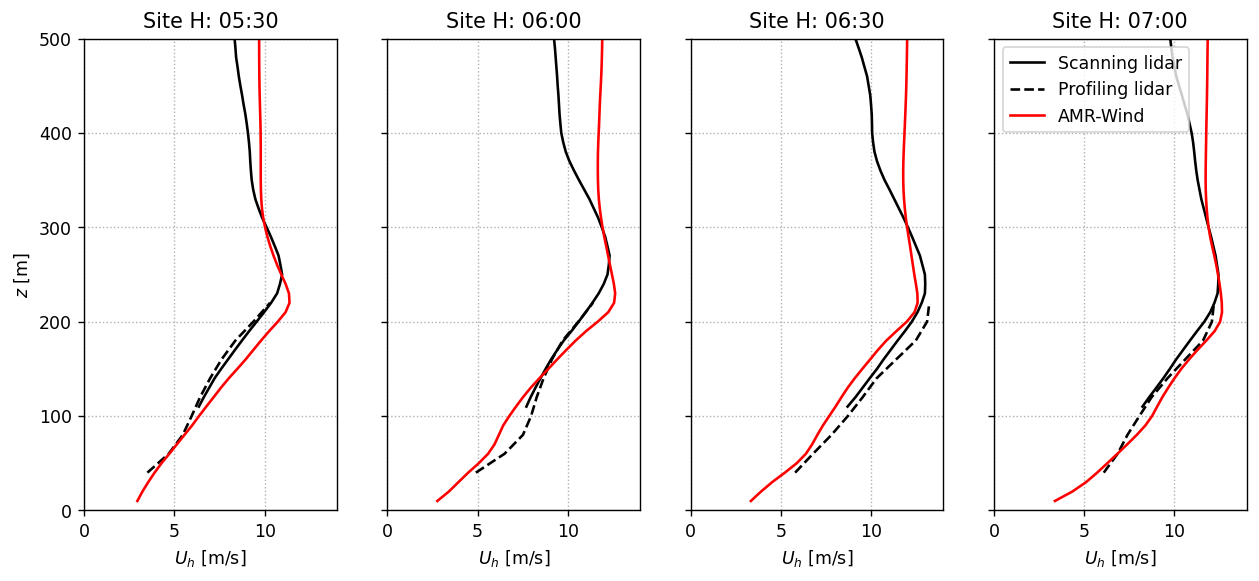

In [14]:
fig, axs = plt.subplots(1, len(tdeltas), figsize=(3*len(tdeltas),5), dpi=125, sharey=True)
for iWS, WS in enumerate(Hscan_WS):
    #plt.figure(figsize=(5,5), dpi=125)
    ax = axs[iWS]
    ax.plot(WS, Hscan_z, color='k', label='Scanning lidar')
    ax.plot(Hprof_WS[iWS], Hprof_z, color='k', ls='--', label='Profiling lidar')
    
    # process AMR-Wind data
    Hamr = AMR_datH[iWS]
    zamr  = np.array(Hamr['z'])
    WSamr = np.array(np.sqrt(Hamr['velocityx_avg']**2 + Hamr['velocityy_avg']**2))
    ax.plot(WSamr, zamr, color='r', ls='-', label='AMR-Wind')
    ax.set_title('Site H: '+str(Hscan_MMCdates[iWS])[11:16])#[:16])
    ax.set_ylim([0, 500])
    ax.set_xlim([0, 14])
    ax.grid(ls=':')
    ax.set_xlabel('$U_h$ [m/s]')
    
axs[0].set_ylabel('$z$ [m]')
axs[-1].legend(loc='upper left')

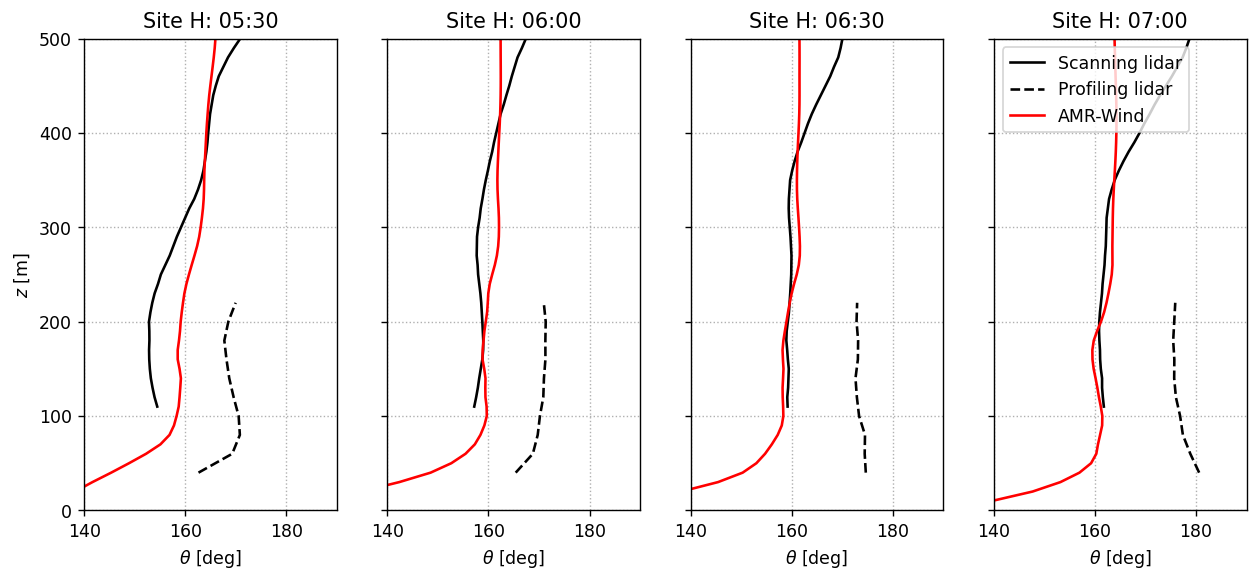

In [22]:
# Plot the wind direction
fig, axs = plt.subplots(1, len(tdeltas), figsize=(3*len(tdeltas),5), dpi=125, sharey=True)
for iWD, WD in enumerate(Hscan_WD):
    #plt.figure(figsize=(5,5), dpi=125)
    ax = axs[iWD]
    ax.plot(WD, Hscan_z, color='k', label='Scanning lidar')
    ax.plot(Hprof_WD[iWD], Hprof_z, color='k', ls='--', label='Profiling lidar')

    # process AMR-Wind data
    Hamr = AMR_datH[iWD]
    zamr  = np.array(Hamr['z'])
    WDamr = 270.0 - np.arctan2( Hamr['velocityy_avg'],  Hamr['velocityx_avg'])*180.0/np.pi 
    ax.plot(np.array(WDamr), zamr, color='r', ls='-', label='AMR-Wind')
    
    ax.set_title('Site H: '+str(Hscan_MMCdates[iWD])[11:16])#[:16])
    ax.set_ylim([0, 500])
    ax.set_xlim([140, 190])
    ax.grid(ls=':')
    ax.set_xlabel('$\\theta$ [deg]')
    
axs[0].set_ylabel('$z$ [m]')
axs[-1].legend(loc='upper left')

In [16]:
# Load AMR-Wind data
AMR_TKEH = []
AMR_dir  = 'AVG_lidar'
for t in tdeltas[:]:
    tsec = t*3600.0
    AMR_TKEH.append(pd.read_csv(AMR_dir+'/siteH_RESTRESS_%i.csv'%tsec))

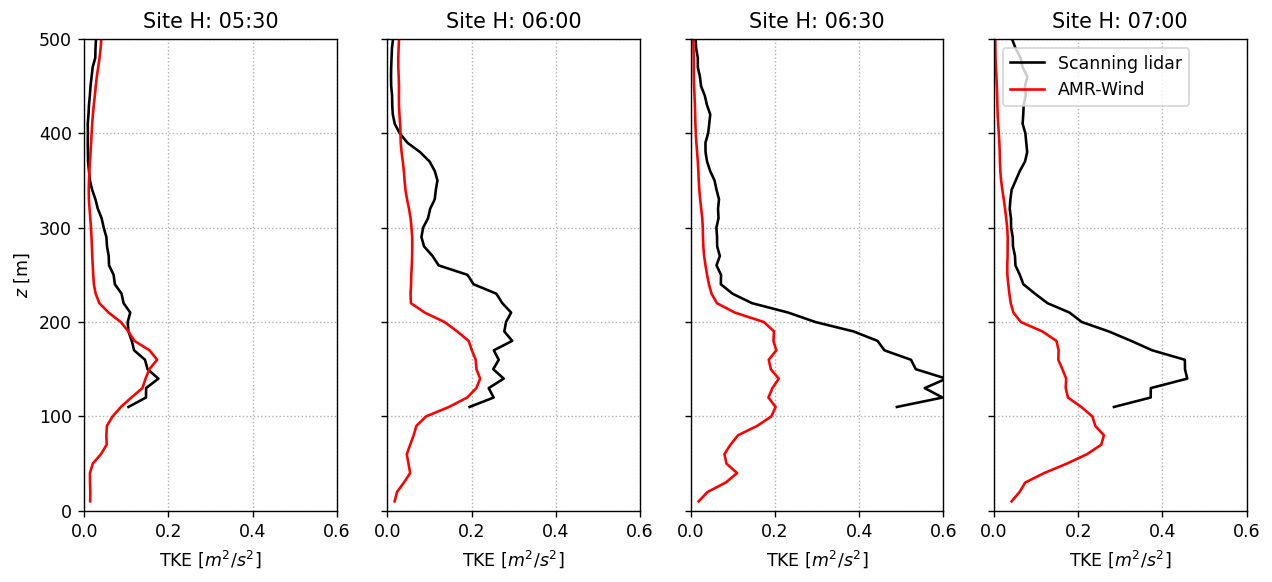

In [17]:
fig, axs = plt.subplots(1, len(tdeltas), figsize=(3*len(tdeltas),5), dpi=125, sharey=True)
for iWS, TKE in enumerate(Hscan_TKE[:]):
    #plt.figure(figsize=(5,5), dpi=125)
    ax = axs[iWS]
    ax.plot(TKE, Hscan_z, color='k', label='Scanning lidar')
    #ax.plot(Hprof_WS[iWS], Hprof_z, color='k', ls='--', label='Profiling lidar')
    
    # process AMR-Wind data
    Hamr = AMR_TKEH[iWS]
    zamr  = np.array(Hamr['z'])
    TKEamr = np.array(0.5*(Hamr['uu_avg'] + Hamr['vv_avg'] + Hamr['ww_avg']))
    ax.plot(TKEamr, zamr, color='r', ls='-', label='AMR-Wind')
    ax.set_title('Site H: '+str(Hscan_MMCdates[iWS])[11:16])#[:16])
    ax.set_ylim([0, 500])
    ax.set_xlim([0, 0.6])
    ax.grid(ls=':')
    ax.set_xlabel('TKE [$m^2/s^2$]')
    
axs[0].set_ylabel('$z$ [m]')
axs[-1].legend(loc='upper left')

## Site C1a

In [18]:
# For scanner
C1aprof_z      = ds_C1aprof['height']
tvec           = ds_C1aprof['time'].data

C1aprof_WS     = []
C1aprof_WD     = []

C1aMMCdates       = []

for t in tdeltas:
    ttarget     = tstart + np.timedelta64(int(t*3600), 's')
    ttarget_m05 = ttarget - np.timedelta64(5, 'm')
    ttarget_p05 = ttarget + np.timedelta64(5, 'm')
    
    im05 = (np.where(tvec == ttarget_m05))[0][0]
    ip05 = (np.where(tvec == ttarget_p05))[0][0]

    WSm05 = ds_C1aprof['U'][im05, :]
    WSp05 = ds_C1aprof['U'][ip05, :]
    
    WDm05 = ds_C1aprof['WD'][im05, :]
    WDp05 = ds_C1aprof['WD'][ip05, :]
    
    WStarget = (WSp05 - WSm05)/(10.0)*(5.0) + WSm05
    WDtarget = (WDp05 - WDm05)/(10.0)*(5.0) + WDm05
    
    C1aMMCdates.append(ttarget)
    C1aprof_WS.append(WStarget)
    C1aprof_WD.append(WDtarget)

In [19]:
# Load AMR-Wind data
AMR_datC1a = []
AMR_dir  = 'AVG_lidar'
for t in tdeltas:
    tsec = t*3600.0
    AMR_datC1a.append(pd.read_csv(AMR_dir+'/siteC1a_RESTRESS_%i.csv'%tsec))

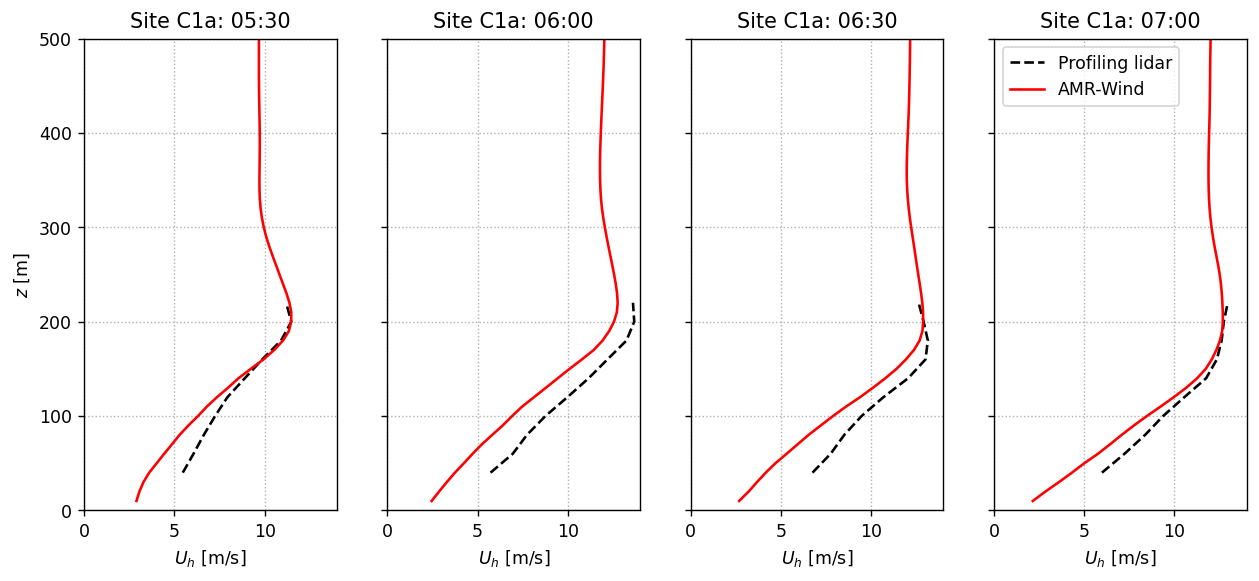

In [20]:
fig, axs = plt.subplots(1, len(tdeltas), figsize=(3*len(tdeltas),5), dpi=125, sharey=True)
for iWS, WS in enumerate(C1aprof_WS):
    #plt.figure(figsize=(5,5), dpi=125)
    ax = axs[iWS]
    ax.plot(C1aprof_WS[iWS], C1aprof_z, color='k', ls='--', label='Profiling lidar')
    
    # process AMR-Wind data
    C1amr = AMR_datC1a[iWS]
    zamr  = np.array(C1amr['z'])
    WSamr = np.array(np.sqrt(C1amr['velocityx_avg']**2 + C1amr['velocityy_avg']**2))
    ax.plot(WSamr, zamr, color='r', ls='-', label='AMR-Wind')
    ax.set_title('Site C1a: '+str(C1aMMCdates[iWS])[11:16])
    ax.set_ylim([0, 500])
    ax.set_xlim([0, 14])
    ax.grid(ls=':')
    ax.set_xlabel('$U_h$ [m/s]')
    
axs[0].set_ylabel('$z$ [m]')
axs[-1].legend(loc='upper left')

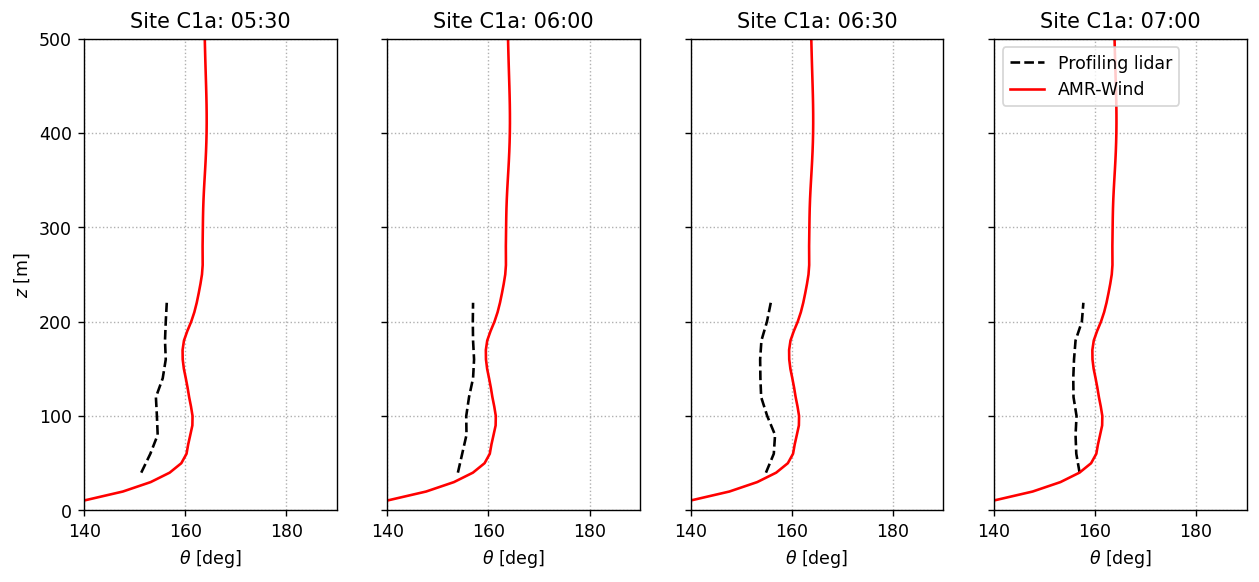

In [23]:
fig, axs = plt.subplots(1, len(tdeltas), figsize=(3*len(tdeltas),5), dpi=125, sharey=True)
for iWD, WD in enumerate(C1aprof_WD):
    #plt.figure(figsize=(5,5), dpi=125)
    ax = axs[iWD]
    ax.plot(C1aprof_WD[iWD], C1aprof_z, color='k', ls='--', label='Profiling lidar')
    
    # process AMR-Wind data
    C1amr = AMR_datC1a[iWS]
    zamr  = np.array(C1amr['z'])
    WDamr = 270.0 - np.arctan2( Hamr['velocityy_avg'],  Hamr['velocityx_avg'])*180.0/np.pi 
    ax.plot(np.array(WDamr), zamr, color='r', ls='-', label='AMR-Wind')
    ax.set_title('Site C1a: '+str(C1aMMCdates[iWD])[11:16])
    ax.set_ylim([0, 500])
    ax.set_xlim([140, 190])
    ax.grid(ls=':')
    ax.set_xlabel('$\\theta$ [deg]')
    
axs[0].set_ylabel('$z$ [m]')
axs[-1].legend(loc='upper left')